# Portfolio Management Lecture 03
### Portfolio Risk Metrics 

In this lecture we'll go through the following risk metrics used in portfolio management: 
- Standard Deviation 
- Semideviation 
- Max Drawdown
- VaR
- CVaR  

Remember that on of the goals of Portfolio management is to **target a certain return while lowering down risk as much as possible**.

In [3]:
# import the required libraries 
import numpy as np # Basic operations
import pandas as pd # Data Manipulation
import matplotlib.pyplot as plt # Data Visualization 
from openbb import obb # Market Data Retrieval
from scipy.stats import norm # To compute the parametric VaR
obb.user.preferences.output_type = 'dataframe'

In [4]:
data = obb.equity.price.historical('SPY',
                                  start_date = '2000-01-01',
                                  end_date = '2025-01-01',
                                  interval = '1M',
                                  provider = 'yfinance')
prices = data['close']  

Financial returns are the basis for our calculations and can be computes using the function pct_change() 

In [5]:
rets = prices.pct_change()[1:] # Dropping the first row since it is NaN 

### Maximum Drawdown
One could ask the question: What is the maximum loss that I could have experienced if I had invested in a given asset over a particular time horizon? This is what the maximum drawdown answers. It is the maximum loss from a peak to a trough of a portfolio (before a new peak is attained).

To compute that we need: 
- The amount of $ invested 
- Previous peaks 
- The distance from a peak to a trough

*Note: Most would just ask "how much can I lose?"

In [6]:
# Creating a function to compute the MaxDD 

def drawdown(rets: pd.Series, initial_investment):
   """
   - Takes the serie of financial returns and computes: 
   - the growth of the investment amount 
   - the previous peaks 
   - the drawdown 
   """
   total_investment = initial_investment*(1+ rets).cumprod() 
   previous_peaks = total_investment.cummax()
   drawdowns = (total_investment - previous_peaks)/previous_peaks 
   return pd.DataFrame({
      'Total Investment': total_investment,
      'Peaks': previous_peaks, 
      'Drawdown': drawdowns
   })

In [8]:
def get_drawdown(rets: pd.Series, initial_investment=1000, plot=True):
    """
    Calculate and optionally plot drawdown analysis
    
    Parameters:
    -----------
    rets : pd.Series
        Series of returns
    initial_investment : float
        Initial investment amount (default: 1000)
    plot : bool
        Whether to create a plot (default: True)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing Total Investment, Peaks, and Drawdown
    """
    # Calculate drawdown metrics
    total_investment = initial_investment*(1 + rets).cumprod() 
    previous_peaks = total_investment.cummax()
    drawdowns = (total_investment - previous_peaks)/previous_peaks 
    
    # Create DataFrame
    df_drawdown = pd.DataFrame({
        'Total Investment': total_investment,
        'Peaks': previous_peaks, 
        'Drawdown': drawdowns
    })
    
    # Create plot if requested
    if plot:
        plt.figure(figsize=(12, 6))
        df_drawdown[['Total Investment', 'Peaks']].plot(
            color=('r', 'b'),
            title='Drawdown'
        )
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    
    return df_drawdown.min()


<Figure size 1200x600 with 0 Axes>

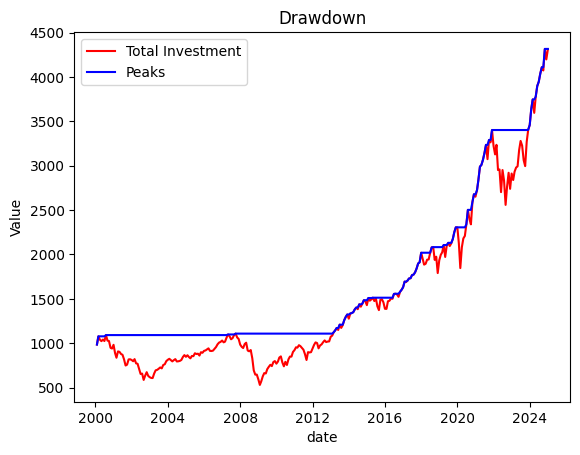

Total Investment    529.726827
Peaks               984.773847
Drawdown             -0.521953
dtype: float64

In [9]:
get_drawdown(rets, plot = True)

Let's interpret the results. 

If one had invested 1.000 $ at the beginning of 2000 at a certain point he would have lost about 52% of the initial investment. The acute reader might notice a disappointing performance from Jan 2000 to Dec 2009. This period has been referred as the **lost decade** 
where the S&P 500 (that had averaged more than 10% annualized returns before 2000) delivered less-than-average returns from the start of the decade to the end. 

#### Value at Risk (Var)

**Value at Risk (VaR)** is a risk metric that estimates: 
- the minimum loss
- expected over a defined time horizon
- at a given confidence level.

Example/

If a portfolio has a 5% VaR of $1 million over a one-day period, it means that there is a 5% chance (roughly, one day out of every 20) that the portfolio will incur a loss of at least $1 million in a single day.

There are several methods to compute VaR. We will focus on two approaches:

1) **Historical Simulation**
2) **Parametric Method**